# List of imports

The following list of imports should be sufficient to work on the project.

In [28]:
import math
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import OrGate
from qiskit.circuit.library.standard_gates import RYGate
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Operator
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from itertools import product
from scipy.stats import norm, lognorm


# Standard pricing of a call option

The code below permits to compute the price of a call option using the Black-Scholes closed formula, and then approximating it using a Monte Carlo method.

## Black-Scholes price of the call option

Definition of the function implementing the closed formula for the price of a call option

In [29]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price for a European call option.
    
    :param S: Current stock price
    :param K: Strike price
    :param T: Maturity (in years)
    :param r: Risk-free interest rate (annual)
    :param sigma: Volatility of the stock (annual)
    :return: Call option price
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

### Characteristics to price the call option

In [30]:
# Financial characteristics that are also required to compute the probability distribution
sigma = 0.2 # volatility (annualized)
T = 1 # maturity (in years)
r = 0.05 # risk-free rate (annualized)
S0 = 2 # initial stock price
K = 2 # strike price

Evaluation of the price for the given set of parameters

In [31]:
call_price = black_scholes_call(S0, K, T, r, sigma)
print(f"Call option price: {call_price}")

Call option price: 0.20901167144371136


## Compounded Black-Scholes price of the call option

In this project, we are actually interested in the compounded value of the call price. Data is stored in dictionaries.

Dictionary for the pricing characteristics

In [32]:
price_dict = {'S0': S0, 'r': r, 'sigma': sigma, 'T': T}

print(price_dict)

{'S0': 2, 'r': 0.05, 'sigma': 0.2, 'T': 1}


In [33]:
def compound_black_scholes_call(price_dict, K):
    """
    Calculate the Black-Scholes price for a European call option.
    
    :param S: Current stock price
    :param K: Strike price
    :param T: Maturity (in years)
    :param r: Risk-free interest rate (annual)
    :param sigma: Volatility of the stock (annual)
    :return: Call option price
    """
    S0 = price_dict['S0']
    T = price_dict['T']
    r = price_dict['r']
    sigma = price_dict['sigma']
    call_price = black_scholes_call(S0, K, T, r, sigma)
    compound = np.exp(r * T)
    return compound * call_price

In [34]:
compound_call_price = compound_black_scholes_call(price_dict, K)
print(f"Compounded call option price: {compound_call_price}")

Compounded call option price: 0.21972792899401578


## Monte Carlo evaluation of the compounded price of the call option

Complete the code below to evaluate the compounded price of the call option. A sample of $\mathcal{N}(0,1)$ can be generated using the command `random.standard_normal` from **numpy**

In [35]:
def monte_carlo_black_scholes(price_dict, K, num_simulations):
    """
    Monte Carlo simulation for Black-Scholes option pricing.
    
    :param price_dict: Dictionary containing the pricing characteristics
    :param K: Strike price
    :param num_simulations: Number of Monte Carlo simulations
    :return: Option price
    """
    # Retrieve pricing characteristics
    S0 = price_dict['S0']
    T = price_dict['T']
    r = price_dict['r']
    sigma = price_dict['sigma']
    # Generate random price paths
    payoffs = np.zeros((num_simulations, 2))
    G = np.random.normal(0, 1, [1,num_simulations])
    ST = S0*np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*G)
    payoffs[:, 1] = ST - K


    compound_option_price = np.sum(np.amax(payoffs, axis=1))/float(num_simulations)
    
    return compound_option_price

In [36]:
monte_carlo_black_scholes(price_dict, K, 500000)


np.float64(0.21991814666868653)

# Storing a linear function in a quantum state

## Presentation
The goal of this part is to construct a circuit that permits to encode an affine function $f: x\mapsto a + bx$ on $n$ qubits, under the constraint that $a$ and $b$ are such that $f(x) \in [0,1]$ for all $x\in \{0, \ldots, 2^n-1\}$.

The encoding is based on the approximation $\sin^2\left(y + \frac{\pi}{4}\right) = y + \frac{1}{2} + O\left(y^3\right)$, where $y$ is replaced by $d\cdot\left(f(x) + \frac{1}{2}\right)$.

## Encoding the affine function

Creation of a method `encode_affine_function`$(n,a,b)$ that encodes the function $f$ defined above into a circuit using rotation gates.

In [37]:


def encode_affine_function(n, a, b):
    qc = QuantumCircuit(n+1)

    qc.ry(2*a, 0)

    for k in range(1, n+1):
        qc.cry(b*2**k, k, 0)

    return qc





## Testing the circuit

Definition of a method `convert_affine`$(a,b,d)$ that outputs values `a_out` and `b_out` for the transformed affine function.

In [38]:
def convert_affine(a,b,d):
    a_out = d*(a-0.5)+np.pi/4
    b_out = d*b
    return a_out, b_out

The `get_one_prob` method below permits to compute the probability of reading value '1' on qubit $0$ upon a measurement. 

In [39]:
def get_one_prob(qc, numshots):
    job = SamplerV2().run([qc], shots=numshots)
    result = job.result()
    #print(result[0].data.shape.count('1'))
    #prob = result[0].data.shape.count('1')/numshots
    prob = result[0].data.cl.get_counts()['1']/numshots
    #print(f"Probability: {prob}")

    return prob



Creation of a method `add_measurement`(`qc`) method that copies circuit `qc`, adds a classical register with a single bit to the new copy and adds a measurement of qubit $0$ with the result stored in the classical bit. The resulting circuit will be used to guarantee that the circuit correctly encodes the affine function.

In [40]:
def add_measurement(qc: QuantumCircuit):
    cr = ClassicalRegister(1)
    qc.add_register(cr)
    qc.measure(0, cr)
    return qc


### Validation

In [41]:
# Number of qubits in the circuit
n_test = 3

# Arbitrary value for b
b_test = 1.0/(2**n_test)

# Arbitrary value for a, with the constraint that 0 <= f(x) <= 1 for all x
a_test = 1.0/(2**(n_test+1))

# Arbitrary value for d
d_test = 0.1

In [42]:
pure_affine = encode_affine_function(n_test, a_test, b_test)

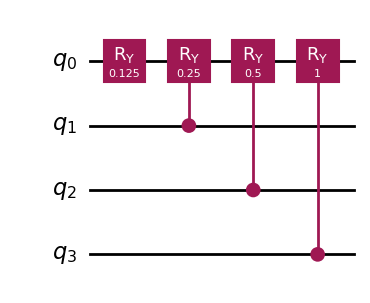

In [43]:
pure_affine.draw(output='mpl')

In [44]:
measure_affine = add_measurement(pure_affine)

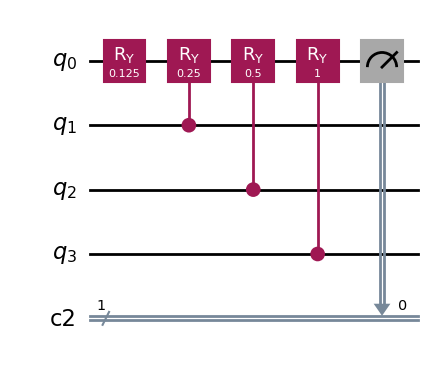

In [45]:
measure_affine.draw(output='mpl')

Creation of a method `initializer`$(qc,i)$ that takes as an input a quantum circuit $qc$ consisting of $n$ qubits and an integer $0\leq i \leq 2^{n} -1$, and creates a new quantum circuit in which the initial state is $|i\rangle$.

In [46]:
def initializer(qc: QuantumCircuit, i: int) -> QuantumCircuit:
    """
    Je suppose que la notation |i> c'est la meme que |i>n, donc l'ecriture binaire de i
    :param qc:
    :param i:
    :return:
    """
    n_qubits = qc.num_qubits
    # Get binary representation of i with leading zeros
    i_bin = format(i, f'0{n_qubits}b')

    # Apply X gates to qubits where the corresponding bit is 1
    for qubit, bit in enumerate(reversed(i_bin)):  # Reverse because qubit 0 is least significant bit
        if bit == '1':
            qc.x(qubit)
    return qc





We provide below a method `compare_values`$(n,a,b,d,i)$ that compares the expected value 
$$d\cdot\left(f(i)-\frac{1}{2}\right) + \frac{1}{2} = d\cdot\left(a+i\cdot b - \frac{1}{2}\right) + \frac{1}{2}$$
with the probability of measuring value $1$ in the constructed circuit. The method prints the expected value, the probability of measuring the value $1$ and the relative error between both.

This method is in charge of:
- Invoking `convert_affine` to get the appropriate parameters for the encoded affine function
- Creating the initial circuit (`encode_affine_function`)
- Invoking the `initializer` to set the desired initial state
- Adding a classical bit to measure the first qubit (`add_measurement` method) and using the `get_one_prob` method to compute the probability of measuring the value $1$

In [47]:
def compare_values(n, a, b, d, i):
    a_out, b_out = convert_affine(a, b, d)
    encoded_qc = encode_affine_function(n, a_out, b_out)
    initialized_qc = initializer(encoded_qc,i)
    measured_qc = add_measurement(initialized_qc)
    output_prob = get_one_prob(measured_qc, 10000)
    expected_value = d*(a+b*i -0.5) + 0.5
    relative_error =(expected_value-output_prob)/expected_value
    print(f'Expected value: {expected_value}, measured output: {output_prob}, relative error: {relative_error:.2%}')

In [48]:
def compare_all_values(n, a, b, d):
    for i in range(2**n):
        compare_values(n, a, b, d, i)

In [49]:
#compare_all_values(n_test, a_test, b_test, d_test)

# A quantum circuit for integer comparison

The goal of this part is to construct a circuit of size $n$, parameterized by an integer $0\leq L \leq 2^n-1$, that permits to detect whether a given state $|i\rangle$ is such that $i < L$ or $i\geq L$.

## Creation of the 'or' gate

Definition of a method `or_gate`() that constructs a quantum circuit representing an *or* gate using the method described in the exercise sheet. The resulting circuit can be used as a standard gate thanks to the `to_gate()` method. It will be necessary to invoke the `transpile` method before measurement outcomes can be computed.

In [50]:
def or_gate()->QuantumCircuit:
    qc = QuantumCircuit(3, name='OR')
    qc.x(range(3))
    #qc.barrier()
    qc.ccx(2, 1, 0)
    #qc.barrier()
    qc.x([1,2])
    return qc

We can verify that the *or* gate has the appropriate behavior by computing the probabilities of measuring a $1$ on qubit $2$ for different initial states.


**Useful methods**: 
- The `initialize` method defined above.
- The `to_gate()` instruction can be used to convert a circuit into a gate.
- The `transpile()` instruction allows the AerSimulator to convert the *or* gate back to known gates.

In [51]:
dict_num = {
    "0 OR 0": 0,
    "1 OR 0": 2,
    "0 OR 1": 4,
    "1 OR 1": 6,
}
for label, initial_state in dict_num.items():
    qc = QuantumCircuit(3, 1)
    qc = initializer(qc, initial_state)

    or_circuit = or_gate()
    # Je compose les deux circuits, mais on pourrait convertir en gate, ce qui sera d'ailleur utile pour la suite
    qc = qc.compose(or_circuit)

    qc.measure(0, 0)

    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=1024).result()
    counts = result.get_counts()

    print(f"{label} = {list(counts.keys())[0]}")

0 OR 0 = 0
1 OR 0 = 1
0 OR 1 = 1
1 OR 1 = 1


## Construction of the comparator circuit

Definition of a `make_comparator`$(n,L)$ method that creates a circuit $q$ of size $2n$ such that, when state $|i\rangle \otimes |0^n\rangle$ is fed as an input, we obtain a state $|x_{2n-1}\cdots x_0\rangle$ as an output with $|x_0\rangle = |0\rangle$ exactly when $i < L$. 

In [52]:
def make_comparator(n: int, L: int) -> QuantumCircuit:
    q = QuantumCircuit(2*n)
    or_circuit = or_gate()
    gate_or = or_circuit.to_gate(label='OR')

    l_to_binary = format(2**n - L, f'0{n}b')
    if l_to_binary[n - 1] == '1':
        q.cx(n, n-1)
        q.barrier()
    for j in range(1, n):
        if l_to_binary[n-1-j] == '1':
            q.append(gate_or, [n+j, n-j, n-j-1])
            q.barrier()
        else:
            q.ccx(n+j, n-j, n-j-1)
            q.barrier()

    return q

An example when $n=3$ and $L=5$

In [53]:
cmp_qc = make_comparator(3, 5)

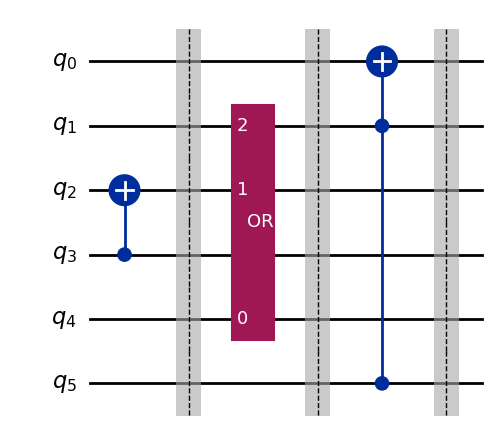

In [54]:
cmp_qc.draw(output='mpl')

Definition of a `check_comparison`$(n,L, nb)$ method that invokes the `make_comparator` method, iterates over $0\leq i\leq 2^n-1$ to initialize the circuit with state $|i\rangle \otimes |0^n\rangle$ and verifies that the measurement of the qubit at index $0$ returns the appropriate value for each value of $i$. Parameter $nb$ represents the number of shots used by the sampler to compute measurement outcome statistics.

In [92]:
def check_comparison(n, L, numshots):
    comp_qc = make_comparator(n, L)
    #line below useless?
    simulator = AerSimulator(method='statevector')
    sampler = SamplerV2()   
    for i in range(2**n):
        qr = QuantumRegister(2*n)
        qci = QuantumCircuit(qr)
        init = [0 for _ in range(2**n)]
        init[i] = 1
        qci.initialize(init, qr[n:2*n])
        res_qc = qci.compose(comp_qc)
        meas_qc = add_measurement(res_qc)
        qc = transpile(meas_qc, simulator)
        job = sampler.run([qc], shots=numshots)
        result = job.result()
        prob = result[0].data.cl.get_counts()
        print(f'Test if {i} >= {L}, measured output: {prob}')

In [56]:
#check_comparison(4, 10, 1024)


# Storing a probability distribution in a quantum state

The goal of this part is to design a circuit that permits to store a probability distribution in a quantum state.

## Case where $n=2$

We begin with the simple case where $n=2$. The cell below constructs a circuit permitting to store the probability distribution in a quantum state (with a single qubit). 

In [96]:
def make_basic_qc(p):
    qc =  QuantumCircuit(1)
    theta = 2*math.acos(math.sqrt(p))
    qc.ry(theta, 0)
    return qc 

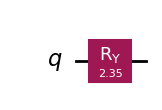

In [97]:
make_basic_qc(0.15).draw(output='mpl')

In [98]:
def get_state_probabilities(qc):
  n = qc.num_qubits
  statevector = Statevector(qc)
  probabilities = {}
  for i in range(2**n):
    state = bin(i)[2:].zfill(n)
    probabilities[state] = abs(statevector[i])**2  
  return probabilities

In [99]:
get_state_probabilities(make_basic_qc(0.15))

{'0': np.float64(0.1499999999999999), '1': np.float64(0.8500000000000001)}

The probability of getting the outcome $0$ is close to $p$, likewise for $1$ and $1-p$.

## Circuit for an arbitrary value of $n$.

### Generation of the final prices grid

Definition of a method `make_final_price_grid`$(n, \mathrm{price\_dict}, m)$ that generates a regular grid with size $2^n$ of final prices ranging between $\max\left(0, \overline{S} - m\cdot \sigma\right)$ and $\overline{S} + m\cdot \sigma$. This method is based on the `linspace` method from **numpy**.

In [143]:
def make_final_price_grid(n: int, price_dict: dict, m: int):

    S = price_dict['S0']
    T = price_dict['T']
    sigma = price_dict['sigma']
    r = price_dict['r']

    s1 = S*np.exp(r*T)

    sm = max(0, s1 - m*sigma)
    sM = s1 + m*sigma


    return np.linspace(sm, sM, 2**n)


make_final_price_grid(5, price_dict, 3)[0]


np.float64(1.5025421927520481)

Definition of a method `align`$(n, K, \mathrm{price\_dict}, m)$ that returns the value $L$ such that $s_L$ is the projection of $K$ on the final price grid. 

In [151]:
def align(n, K, price_dict, m):
    grid = make_final_price_grid(n, price_dict, m)
    L = np.argmin(np.abs(grid - K))
    return grid[L]

def align_for_L(n, K, price_dict, m):
    grid = make_final_price_grid(n, price_dict, m)
    L = np.argmin(np.abs(grid - K))
    return L


Test of the discretization error by comparing the outputs of `compound_black_scholes_call` on an arbitrary strike and on its projection on the final price grid.

In [63]:
init_cpb = compound_black_scholes_call(price_dict, price_dict['S0'])
disc_cpb = compound_black_scholes_call(price_dict, align(5,price_dict['S0'], price_dict, 3))

In [64]:
print(f'init: {init_cpb}, disc: {disc_cpb}, error: {(init_cpb-disc_cpb)/init_cpb:.2%}')

init: 0.21972792899401578, disc: 0.2165164556850805, error: 1.46%


### Generation of the probability values

Definition of a method `make_probability_distribution` that returns a *last prices* grid and the corresponding value of each $p_i$ for $0 \leq i < 2^n$. The arguments of this method are:
- $n$: the number of qubits under consideration
- $\mathrm{price\_dict}$: the dictionary with the mathematical characteristics of the underlying
- $m$: the number of standard deviations to consider for the minimum and maximum bounds of the grid

***Useful methods:*** 
$S_T$ is of the form $S_0e^{(r-\tfrac{\sigma^2}{2})T}\cdot Z$, where $Z \sim \mathrm{lognorm}(\sigma\sqrt{T})$. The lognormal distribution is available thanks to the `lognorm` method from `scipy.stats`. The `scale` parameter is to be set to $1$.

The probability values can be computed using the `cdf` method available on the lognormal distribution.

In [65]:
def make_probability_distribution(n, pr_dict, num_stddev):
    """
    Generate the probability distribution for the final stock prices.
    
    :param n: Number of qubits
    :param pr_dict: Dictionary with the financial characteristics
    :return: Probability distribution
    """
    # Generate the log-normal distribution
    S0 = pr_dict['S0']
    r = pr_dict['r']
    T = pr_dict['T']
    sigma = pr_dict['sigma']

    lognorm_dist = lognorm(sigma*np.sqrt(T), scale=1)

    final_prices = make_final_price_grid(n, pr_dict, num_stddev)
    sm = final_prices[0]
    sM = final_prices[-1]
    sM1 = sM + (sM-sm)/(2**n - 1)

    final_prices_extra = np.append(final_prices, sM1)

    def s(i):
        si = final_prices_extra[i]/(S0*np.exp((r-0.5*sigma**2)*T))
        return si

    numerateur = [lognorm_dist.cdf(s(i+1)) - lognorm_dist.cdf(s(i)) for i in range(2**n)]
    prob_distribs = numerateur/np.sum(numerateur)

    return final_prices, prob_distribs


## Validation of the probability distribution, comparison of the Black-Scholes approximation

In [66]:
# Arbitrary value for n, will afterward be the size of the quantum circuit
n_prob = 10
n_stddev_prob = 4


Verification that the generated distribution sums to $1$.

In [130]:
final_prices, prob_distribs = make_probability_distribution(n_prob, price_dict, n_stddev_prob)
final_prices_test, prob_distribs_test = make_probability_distribution(5, price_dict, 4)
np.sum(prob_distribs_test)

np.float64(1.0)

Plot the generated distribution against the final price grid.

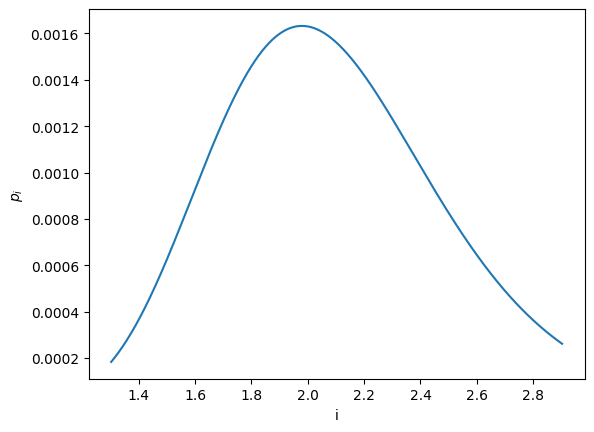

In [68]:
plt.plot(final_prices, prob_distribs)
plt.xlabel('i')
plt.ylabel('$p_i$')
plt.show()

Compare the compounded Black-Scholes price of an option with the approximation of the expectation 
$$\mathbb{E}\left[(S_T - s_L)_+\right] \approx \sum_{i=0}^{2^n-1}p_i\cdot(s_i - s_L)_+.$$

In [69]:
def expectation_cmp(n, L, price_dict, n_stddev):
    last_prices, prob_distribs = make_probability_distribution(n, price_dict, n_stddev)
    sL = last_prices[L]
    sum = 0
    for i in range(0, 2**n):        
        sum += (last_prices[i] - sL)*prob_distribs[i]*(i>=L)
    bs = compound_black_scholes_call(price_dict, sL)
    return {'bs': bs, 'sum': sum, 'strike': sL}

In [70]:
def get_all_expect_comp(n, price_dict, num_stddev, num_points):
    res = []
    for L in range(0, 2**n,int(2**n/num_points)):
        ex_cmp = expectation_cmp(n, L, price_dict, num_stddev)
        print(f'L: {L} (strike {ex_cmp["strike"]})')
        res.append(ex_cmp)
    return res

In [71]:
res = get_all_expect_comp(n_prob, price_dict,n_stddev_prob, 20)

L: 0 (strike 1.3025421927520482)
L: 51 (strike 1.3823075886464764)
L: 102 (strike 1.4620729845409044)
L: 153 (strike 1.5418383804353326)
L: 204 (strike 1.6216037763297608)
L: 255 (strike 1.701369172224189)
L: 306 (strike 1.7811345681186173)
L: 357 (strike 1.8608999640130452)
L: 408 (strike 1.9406653599074735)
L: 459 (strike 2.0204307558019017)
L: 510 (strike 2.1001961516963297)
L: 561 (strike 2.179961547590758)
L: 612 (strike 2.259726943485186)
L: 663 (strike 2.339492339379614)
L: 714 (strike 2.4192577352740425)
L: 765 (strike 2.499023131168471)
L: 816 (strike 2.5787885270628985)
L: 867 (strike 2.658553922957327)
L: 918 (strike 2.7383193188517554)
L: 969 (strike 2.8180847147461834)
L: 1020 (strike 2.8978501106406114)


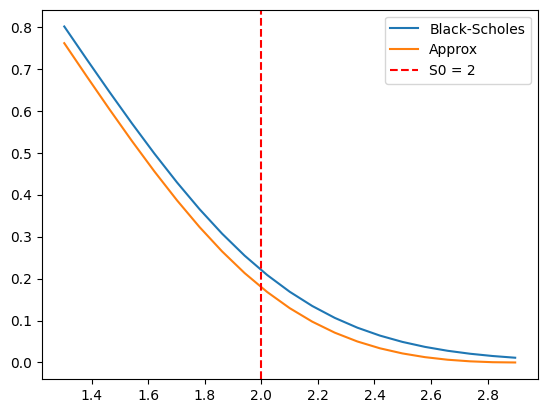

In [72]:
resbs = [x['bs'] for x in res]
ressum = [x['sum'] for x in res]
strikes = [x['strike'] for x in res]
xcoord = price_dict['S0']
plt.plot(strikes, resbs, label='Black-Scholes')
plt.plot(strikes, ressum, label='Approx')
plt.axvline(x=xcoord, color='r', linestyle='--', label=f'S0 = {xcoord}')
plt.legend()
plt.show()

In [73]:
abs_errors = [(x['sum'] - x['bs']) for x in res]
abs_errors

[np.float64(-0.039790820606088295),
 np.float64(-0.040624793195063624),
 np.float64(-0.04137968045038409),
 np.float64(-0.04201165918374339),
 np.float64(-0.04246955264979785),
 np.float64(-0.04269992779191878),
 np.float64(-0.04265306390566076),
 np.float64(-0.042288452938113064),
 np.float64(-0.041578753585550965),
 np.float64(-0.04051164770356755),
 np.float64(-0.03908960526586805),
 np.float64(-0.03732798134959156),
 np.float64(-0.035252075110969436),
 np.float64(-0.03289379287249733),
 np.float64(-0.030288438884452797),
 np.float64(-0.027471980789852992),
 np.float64(-0.024478960243704502),
 np.float64(-0.021341076954474722),
 np.float64(-0.01808637943480724),
 np.float64(-0.01473894580958613),
 np.float64(-0.011318923234109502)]

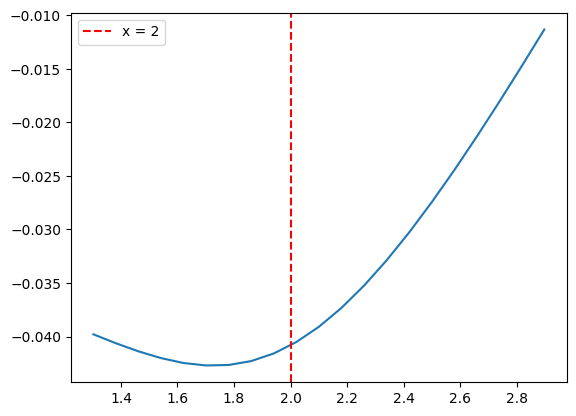

In [74]:
plt.plot(strikes, abs_errors)
xcoord = price_dict['S0']
plt.axvline(x=xcoord, color='r', linestyle='--', label=f'x = {xcoord}')
plt.legend()
plt.show()

## Recursive distribution computations

Computation of the values $q_w$ and $\theta_w$. The values of $q_w$ (resp. $\theta_w$) where $w$ is of length $m$ are stored in a dictionnary for which each key is a string of length $m$. The dictionnaries with the values of $q$ (resp. $\theta$) for $1 \leq m \leq n$ are stored in a dictionnary `DictQ` (resp. `DictTheta`).

Definition of a function `generate_binary_strings`$(n)$ that takes a parameter $n$ and outputs a list of all binary strings of length $n$.

Useful method: `product` from the `itertools` package

In [75]:
def generate_binary_strings(n: int):
    return list(product([0, 1], repeat=n))



Definition of a method `make_dict_at_n` that creates the dictionary containing the values $q_w$ where $w$ is of length $n$. This method has two parameters:
- the value of $n$
- the probability distribution under consideration

In [76]:
def make_dict_at_n(n, prob_distribs):
    w1 = generate_binary_strings(n)
    qw = {}
    for k in range(len(w1)):
        w = ''.join(map(str, w1[k]))
        qw[w] = prob_distribs[k]
    return qw

In [131]:
dict_n = make_dict_at_n(n_prob, prob_distribs)
dict_n_test = make_dict_at_n(5, prob_distribs_test)

Definition of a method `make_all_dictQ` that iterates from $n-1$ to $1$ to generate all the required probability distributions. Note that the set of keys in the generated dictionary is $\{1, \ldots, n\}$. This method has two parameters:
- the value of $n$
- the dictionary containing the probability distribution at level $n$ (generated by `make_dict_at_n`)

In [78]:
def make_all_dictQ(n, dict_n):
    q_all_dict = {}
    m = n-1
    q_all_dict[n] = dict_n
    while m > 0:
        binary_strings_tuples = generate_binary_strings(m)
        q_all_dict[m] = {}
        for k in range(len(binary_strings_tuples)):
            binary_strings = ''.join(map(str,binary_strings_tuples[k]))
            q_all_dict[m][binary_strings] = q_all_dict[m + 1][binary_strings + '0'] + q_all_dict[m + 1][binary_strings + '1']
        m = m-1
    return q_all_dict

In [132]:
dict_all_q = make_all_dictQ(n_prob, dict_n)
dict_all_q_test = make_all_dictQ(5, dict_n_test)
dict_all_q

{5: {'00000': np.float64(0.007322765536620776),
  '00001': np.float64(0.010506247975778519),
  '00010': np.float64(0.014376522791152866),
  '00011': np.float64(0.018847422161380186),
  '00100': np.float64(0.023766617781231524),
  '00101': np.float64(0.028928532414019752),
  '00110': np.float64(0.03409447920222869),
  '00111': np.float64(0.03901642782811171),
  '01000': np.float64(0.04346058691122334),
  '01001': np.float64(0.04722755078328395),
  '01010': np.float64(0.050166804812969125),
  '01011': np.float64(0.052184598691229635),
  '01100': np.float64(0.053245313019380194),
  '01101': np.float64(0.053367287713202094),
  '01110': np.float64(0.05261458015610048),
  '01111': np.float64(0.05108628970981495),
  '10000': np.float64(0.04890498993318155),
  '10001': np.float64(0.04620554074173151),
  '10010': np.float64(0.04312519903789197),
  '10011': np.float64(0.03979558147158503),
  '10100': np.float64(0.036336707958389926),
  '10101': np.float64(0.032853097820834544),
  '10110': np.flo

Definition of a method `make_all_dictTheta` that iterates from $0$ to $n-1$ to generate all the required angles. Note that the set of keys in the generated dictionary is $\{0, \ldots, n-1\}$. This method has a single parameter: the dictionary generated by `make_all_dictQ`.

For the sake of convenience, the element at key $0$ in the generated dictionary will be the angle $\theta^{[0]}_\varepsilon$ instead of a dictionary containing this angle (with the empty string as a key).

In [80]:
def make_all_dictTheta(n, dict_all_q):
    theta_all_dict = {0: {'0': 2 * np.arccos(np.sqrt(dict_all_q[1]['0']))}}
    for k in range(1, n):
        binary_strings_tuples = generate_binary_strings(k)
        theta_all_dict[k] = {}
        for l in range(len(binary_strings_tuples)):
            binary_strings = ''.join(map(str,binary_strings_tuples[l]))
            w0 = binary_strings + '0'
            theta_all_dict[k][binary_strings] = 2*np.arccos(np.sqrt(dict_all_q[k+1][w0]/dict_all_q[k][binary_strings]))
    return theta_all_dict

In [133]:
dict_all_theta = make_all_dictTheta(n_prob, dict_all_q)
dict_all_theta_test = make_all_dictTheta(5, dict_all_q_test)
dict_all_theta

{0: {'0': np.float64(1.4096760695031458)},
 1: {'0': np.float64(1.9718234572233342), '1': np.float64(1.1122939410063806)},
 2: {'00': np.float64(2.0071863425549186),
  '01': np.float64(1.6136352630902036),
  '10': np.float64(1.3939533681991942),
  '11': np.float64(1.2711374150021824)},
 3: {'000': np.float64(1.8771124267186292),
  '001': np.float64(1.7337967670579457),
  '010': np.float64(1.6312521974945626),
  '011': np.float64(1.556951165642474),
  '100': np.float64(1.5022730165175808),
  '101': np.float64(1.4614381577617568),
  '110': np.float64(1.4305548515830437),
  '111': np.float64(1.4069616966959158)},
 4: {'0000': np.float64(1.7503152884483757),
  '0001': np.float64(1.70577440466394),
  '0010': np.float64(1.6689117302123329),
  '0011': np.float64(1.6381689571089684),
  '0100': np.float64(1.612345839701648),
  '0101': np.float64(1.590511978333033),
  '0110': np.float64(1.5719404197031788),
  '0111': np.float64(1.5560583040941218),
  '1000': np.float64(1.542410282391758),
  '100

Definition of a method `make_qc_for_dict` that creates the general quantum circuit for the storage of a quantum distribution. This method has a unique parameter: the dictionary of rotation angles (generated by `make_all_dictTheta`).

Some useful concepts and methods from Qiskit:
- `RYGate` for $y$-rotation gates that are potentially controlled
- `control`: the method to create the controlled version of a quantum gate. This method takes as parameters the number of control qubits, and possibly the state of the control qubits that will trigger the gate (`ctrl_state`).

In [115]:
def make_qc_for_dict(dict_all_theta: dict) -> QuantumCircuit:
    n = len(dict_all_theta)
    qc = QuantumCircuit(n)

    # premiere rotation
    qc.ry(dict_all_theta[0]['0'], n-1)
    qc.barrier()

    for k in range(1,n):
        binary_strings_tuples = generate_binary_strings(k)

        for l in binary_strings_tuples:
            binary_strings = ''.join(map(str,l))
            ry_gate = RYGate(dict_all_theta[k][binary_strings])
            c5_ry_gate = ry_gate.control(k, ctrl_state=binary_strings)
            qc.append(c5_ry_gate, [n-1-i for i in range(k+1)])
        qc.barrier()

    return qc







In [116]:
prob_distrib_qc = make_qc_for_dict(dict_all_theta)

In [134]:
#prob_distribs_qc_test = make_qc_for_dict(dict_all_theta_test)

In [137]:
#prob_distrib_qc.draw(output='mpl')


## Validation

In [105]:
circ_prob_distrib = get_state_probabilities(prob_distrib_qc)

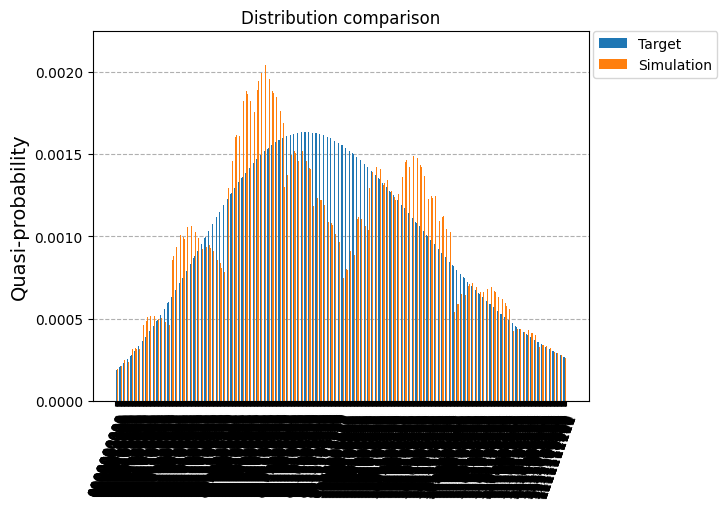

In [106]:
legend=["Target", "Simulation"]
plot_histogram([dict_n, circ_prob_distrib], legend=legend, title="Distribution comparison", bar_labels=False)

Global method that constructs a circuit that stores the probability distribution in a quantum state

In [87]:
def make_distribution_circuit(n, pricing_dict, num_stddev):
    _ ,prob_distrib = make_probability_distribution(n, pricing_dict, num_stddev)
    dict_pn = make_dict_at_n(n, prob_distrib)
    dict_all_q = make_all_dictQ(n, dict_pn)
    dict_all_theta = make_all_dictTheta(n,dict_all_q)
    res = make_qc_for_dict(dict_all_theta)
    return res

# Full integration

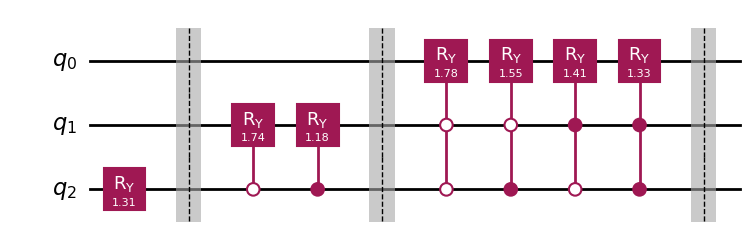

In [107]:
circ_dict = {'n': 3, 'd': 0.01, 'num_stddev': 3, 'm': 3}
K = 2.0
dist_circ = make_distribution_circuit(circ_dict['n'], price_dict, circ_dict['num_stddev'])
dist_circ.draw(output='mpl')

## Creation of the affine functions $f_0$ and $f_1$

Computation of the values $a_i$ and $b_i$ such that $f_i = a_i + b_i\cdot i$.

In [150]:



def f(i, L: int, num=0, circ_dict= circ_dict, price_dict=price_dict):
    d = circ_dict['d']
    sm = price_dict['']
    if num == 0:
        return np.pi/4 - d/2
    else:
        return d*(1)



Comparison of the expectation to estimate with the expectation of its sine approximation.

In [90]:
def compare_expect(circ_dict, price_dict, K):
    # TO COMPLETE
    return mean_f, mean_sin

In [91]:
expect, sin_expect = compare_expect(circ_dict, price_dict, K)

NameError: name 'mean_f' is not defined

In [ ]:
expect, sin_expect

Definition of methods to construct the circuits for $f_0$ and $f_1$ using the `encode_affine_function` method.

## Comparison circuit

Construction of the comparison circuit for a given strike price.

In [ ]:
def make_comparison_circuit(circ_dict, price_dict, K):
    # TO COMPLETE

In [ ]:
cmp_qc = make_comparison_circuit(circ_dict, price_dict, K)

In [ ]:
cmp_qc.draw('mpl')

## Integration

Global integration to construct the global circuit encoding the pricing problem in a quantum state.

In [ ]:
def integration(circ_dict, price_dict, K):
    # TO COMPLETE



In [ ]:
qc_pricer = integration(circ_dict, price_dict, K)

In [ ]:
qc_pricer.draw('mpl')

In [ ]:
def qae_eval(qc_pricer):
    obj_qubits = qc_pricer.find_bit(qc_pricer.qregs[3][0])
    problem = EstimationProblem(state_preparation=qc_pricer, objective_qubits=[obj_qubits.index]) 
    iae = IterativeAmplitudeEstimation(
        epsilon_target=0.01,  # Target accuracy
        alpha=0.05,  # Confidence level
    )
    result = iae.estimate(problem).estimation
    return result

In [ ]:
res = qae_eval(qc_pricer)

In [ ]:
print(f'sin_expect: {sin_expect}, res: {res}')